In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

%matplotlib notebook

# Logging visualization

This notebook operates under the assumption that a `TARDIS` `numba_montecarlo` run has already been completed, with the `log_decorator` enabled for `single_packet_loop`. It then visualizes the progress of packets through shells, depicting different interactions.

TODO: 
- animate packet progress
- include run of TARDIS in the notebook

In [2]:
# TODO: read these in from config file that was used. These are just from TARDIS example.

velocities = np.linspace(1.1e4, 20000, 21)  # km / s
velocities *= 1e5  # cm / s
t_explosion = 10  # days
t_explosion *= 24*60*60 # seconds
radii = velocities * t_explosion

In [3]:
log_file_path = 'sample_montecarlo_log.log'  # change based on where the log file is

In [4]:
def assign_val(string):
    """
    Maps different interactions to a representation that allows for easier plotting.
    """
    if 'LINE' in string:
        return 2
    elif 'BOUNDARY' in string:
        return 1
    else:
        return 0

In [5]:
import ipdb

In [15]:
def plot_packet_from_logs(log_file_path, max_plotted=500, temp_inner=12000):
    """
    Used to track the progress of single packets.
    log_file_path: name of log.
    
    Inputs:
        log_file_path (string): path to log file.
        max_plotted (int, default 500): max number of packets that are plotted.
        
    TODO: get t_inner from model.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = plt.gca()
    ax.set_ylim(-1.9e15, 1.9e15)
    ax.set_xlim(-1.9e15, 1.9e15)
    ax.set_xlabel('Distance (cm)', fontsize=18)
    ax.set_ylabel('Distance (cm)', fontsize=18)
    
    temps = np.power(radii/radii[0], -1/3) * temp_inner # T scales as r^-1/3
    
    def plot_shells():
        norm = mpl.colors.Normalize(vmin=min(temps), vmax=max(temps))
        cmap = mpl.cm.get_cmap('magma')
        for i, r in enumerate(radii[::-1]): # need to fix this
            temp = temps[::-1][i]
            color = cmap(norm(temp))
            ax.add_patch(mpl.patches.Circle((0, 0), r, edgecolor='black',
                                                facecolor=color, alpha=0.5)) # need to do outside in?
    plot_shells()
    xs = [] # n steps x m particles
    ys = []
    interactions_all = []
    ticker = 0
    with open(log_file_path, "r") as file:
        for line in file:
            if 'Output' in line and ticker < max_plotted:
                output = line.split('Output: ')[1][:-2]
                
                interactions = output.split('<')[1:-1]
                interactions = [assign_val(interaction) for interaction in interactions]
                last = output.split('<')[-1].split('>')[0]
                interactions += [assign_val(last)]
            
                r_track_distance = eval('[' + output.split('[')[-1][:-1])
                if None in r_track_distance or 'stop' in r_track_distance:
                    r_track_distance = r_track_distance[0]
                rel_output = output.split(', [<InteractionType.BOUNDARY')[0]
                formatted = rel_output + ')'
                r_track_nu, r_track_mu, r_track_r = eval(formatted)
                r_track_r = np.array(r_track_r)
                r_track_distance = np.array(r_track_distance)
                angle = np.cumsum(np.arccos((r_track_r[:-1] ** 2 + r_track_r[
                                                               1:] ** 2 - r_track_distance[
                                                                          1:] ** 2) / (
                                                    2 * r_track_r[:-1] * r_track_r[
                                                                         1:])))
                x, y = np.sin(angle) * r_track_r[1:], np.cos(angle) * r_track_r[1:]
                x = np.hstack(([0], x))
                y = np.hstack((r_track_r[0], y))
                ax.plot([x[0]], [y[0]], marker='o', color='gray')
#                 ax.plot(x, y, color='gray', alpha=.2)
    # have to load into one larger array
#                 plt.scatter(x[interactions==1], y[interactions==1], marker='o')
#                 plt.scatter(x[interactions==2], y[interactions==2], marker='+')
                xs += [x]
                ys += [y]
                interactions_all += [interactions]
                ticker += 1
                interactions = np.array(interactions)
        try:
#             ax.plot(x, y, marker='x', color='goldenrod', alpha=.2, label='Packet paths')
#             ax.plot(x, y, color='red', label='Last valid packet')
#             ax.scatter(x[interactions==1], y[interactions==1], marker='o', color='red', 
#                        label='Boundary interaction', zorder=10)
#             ax.scatter(x[interactions==2], y[interactions==2], marker='+', color='red',
#                        s=75, label='Line interaction', zorder=10)
#             ax.plot([x[0]], [y[0]], marker='o', color='gray', label='Starting point')

            # ignore interactions for now
#             ipdb.set_trace()
            scat = ax.scatter(xs[0], ys[0], zorder=10)
            plt.legend(fontsize=14, loc='upper right')
            m = plt.cm.ScalarMappable(cmap='plasma')

            cbar = fig.colorbar(m, ax=ax, 
                         boundaries=np.linspace(min(temps), max(temps), 200))
            cbar.set_label(label='Temperature (K)', size=18)

        except UnboundLocalError:
            print('No packets traveled!')
#     animation = FuncAnimation(fig, update, interval=10)
#     plt.savefig('tardis_viz.pdf')
    plt.show()

<IPython.core.display.Javascript object>


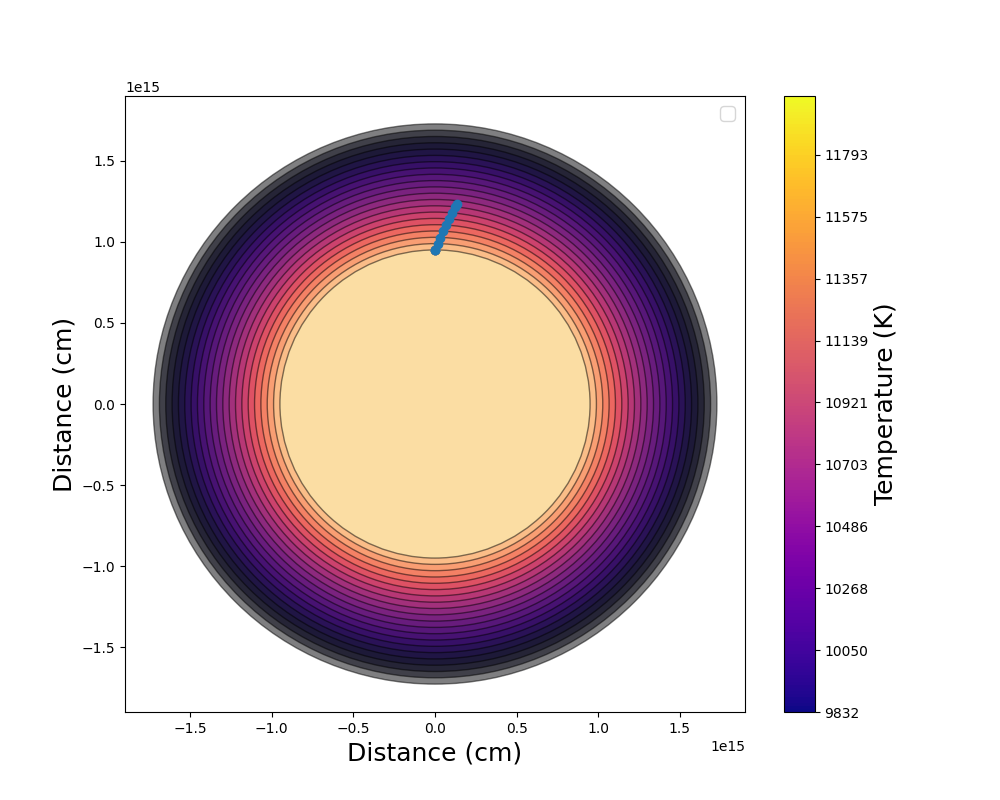

No handles with labels found to put in legend.


In [16]:
plot_packet_from_logs(log_file_path)

In [13]:
arr = np.array([1, 2, 3, 4, 5, 6, 7])

# Outstanding questions
- how many to animate?
    - Look clean: but also have it contain all relevant info
    - \> 2 dozen will be tough
    - Release packets in blocks; gray them out after moving, fade back in at end. summary of all blocks at end
- animate kwarg?
- how to make it look? Colors, etc.
    - GUI color scheme for temperature — but flipped
    - Decrease alpha values, perhaps?
    - black + gray for packets
- step through with each interaction? how many interactions does a packet usually have?
    - look into this. depends on whether pure scattering, macroatom. most people use macroatom
- color code shell by temp: use same color scheme as GUI. include temperature scale?
    - create temp_scale function
- hold the packets in the center
- gray out packets as they move into photosphere
- different modes, different things (assumptions, etc.)
    - nebular!
- darker photosphere?
- arrows on packets that make it to outside...or note what goes into the spectrum somehow
- how to demonstrate interactions?
    - use different color + different symbol for an interaction — test out bc different colors, diff shells
    - probably stick with symbols
- 3D!
    - Use plotly
    - 3D spherically symmetric thing of start then actually move in 2D.
    - d3.js
- Add GIF to PRs

- make a TEP

In [15]:
rgba

(0.9568627450980393, 0.42745098039215684, 0.2627450980392157, 1.0)